# Analysis

## Imports

In [1]:
import sys
import os
import pandas as pd

# Get the current working directory of the notebook
notebook_dir = os.path.abspath(os.getcwd())

# Construct the path to the 'src' directory
ncp_src_path = os.path.abspath(os.path.join(notebook_dir, "..", "ncp", "src"))

# Add the 'src' directory to sys.path
if ncp_src_path not in sys.path:
    sys.path.append(ncp_src_path)

# Now you can import the modules
from analysis import perform_and_save_analysis

from visualization import load_and_print_results


# Suppressing warnings for cleaner output
import warnings

warnings.filterwarnings("ignore")

## Functions

## Load and clean data

In [2]:
data_path = "output/ncp_augmented.parquet"
df = pd.read_parquet(data_path)

# select only rows where the Metadata_line_source is "human"
df = df.query("Metadata_line_source == 'human'")

## Analyze

In [3]:
feature_cols = df.columns[df.columns.str.contains("Cells_|Cytoplasm_|Nuclei_")].tolist()

# HACK to reduce the number of features
feature_cols = feature_cols[:30]

perform_and_save_analysis(
    df=df,
    category_col="Metadata_cell_type",
    target_col="Metadata_line_condition",
    target_col_mapping_dict={"control": 0, "deletion": 1},
    feature_cols=feature_cols,
    output_dir="output/analysis_results/",
)

Analyzing category: stem
Analyzing category: progen
Analyzing category: neuron
Analyzing category: astro
Analysis complete. Summary results saved to output/analysis_results/summary_results.parquet



Category: stem
Logistic Regression Accuracy Score: 0.8056
Number of Significant Features: 20


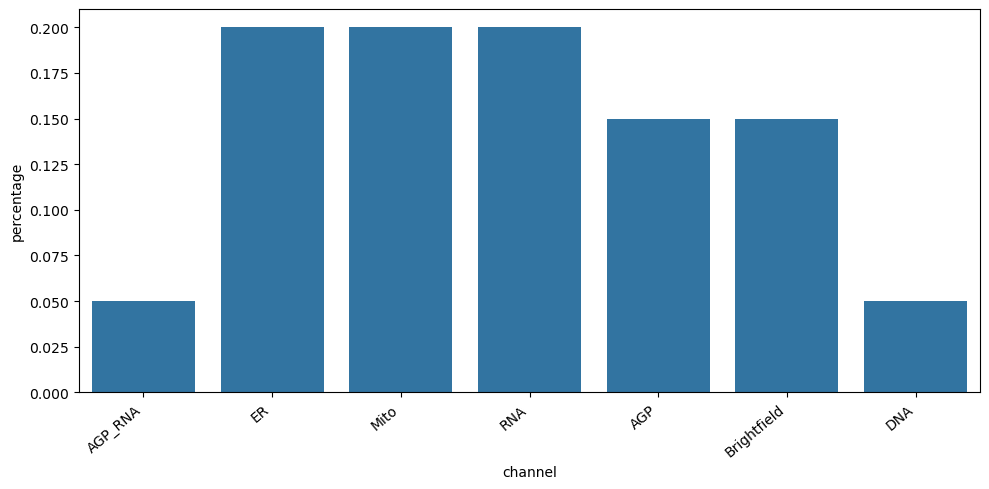


Category: progen
Logistic Regression Accuracy Score: 0.7083
Number of Significant Features: 23


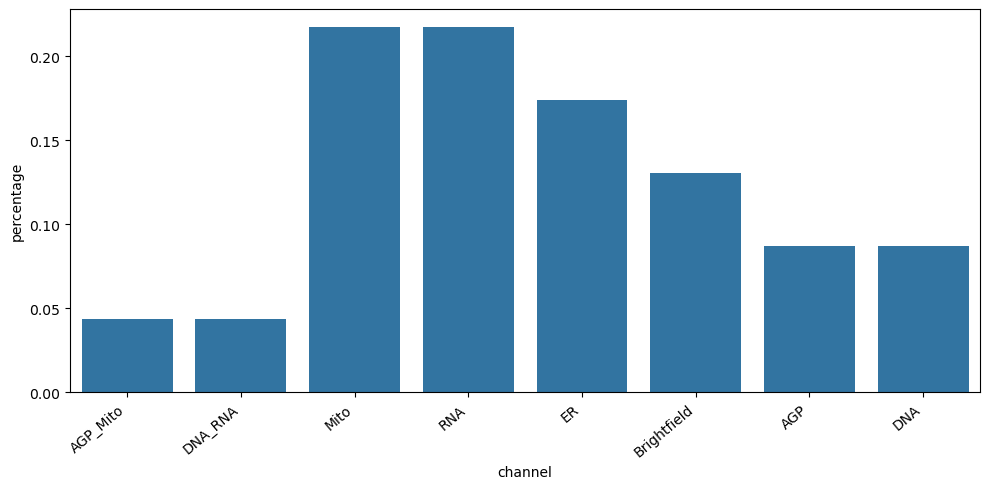


Category: neuron
Logistic Regression Accuracy Score: 0.4097
Number of Significant Features: 0

Category: astro
Logistic Regression Accuracy Score: 0.7222
Number of Significant Features: 23


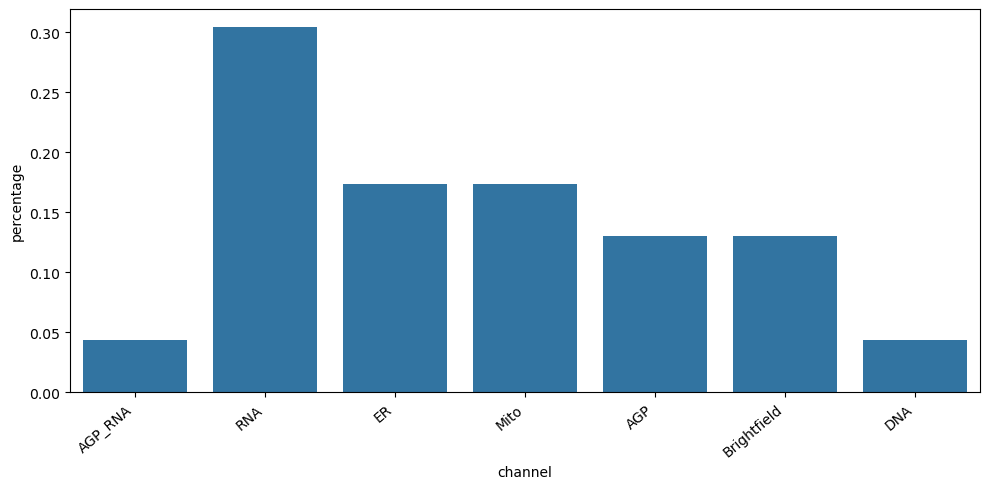

In [4]:
load_and_print_results(input_file="output/analysis_results/summary_results.parquet")